In [1]:
from google.colab import drive
drive.mount('/content/drive')


from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

import torchvision.transforms as transforms
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


Mounted at /content/drive


<class 'torch.Tensor'>
torch.Size([3, 2160, 15360])


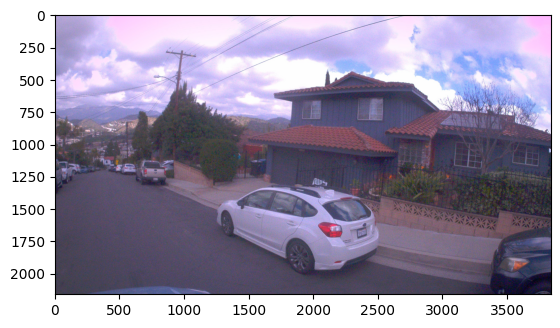

In [2]:
image_path = '/content/drive/MyDrive/SRI Lab/images/color_image_256.jpg'
# /Volumes/JC SSD/SRILab Data/Kaarta/2023-02-11_15-31-02GOOD/images/color_image_256.jpg'

img = read_image(image_path)

plt.imshow(img.permute(1, 2, 0))

# Print type of img
print(type(img))

# Print shape of img
print(img.shape)

# Crop img to middle 50% based on width
img = img[:, :, int(img.shape[2] * 0.50):int(img.shape[2] * 0.75)]

plt.imshow(img.permute(1, 2, 0))

In [4]:
%cd /content/drive/MyDrive/SRI Lab/images

cropped_images = []

# %cd /content/drive/MyDrive/images
count = 0
for filename in os.listdir('.'):  # Iterate through the files in the current directory
    if filename.endswith('.jpg') and count < 50:
        # img = Image.open(filename)
        img = read_image("./"+ filename)
        # plt.imshow(img.permute(1, 2, 0))
        cropped_img = img[:, :, int(img.shape[2] * 0.50):int(img.shape[2] * 0.75)]
        cropped_images.append(cropped_img)
        count = count + 1

# for i in cropped_images:
  # plt.imshow(cropped_images[i])

/content/drive/.shortcut-targets-by-id/1jKx0lEmDB_lwriMB6CGeBnunavDxJEUb/images


In [5]:
# Load the LRV file into a Python script using a video processing library like OpenCV.

# Extract the frames from the video sequence and process them individually.

# Use a computer vision algorithm to detect cars in each frame. You could use a pre-trained object detection model like YOLO or Faster R-CNN to perform this task. Alternatively, you could use a feature-based approach like Haar cascades or HOG-SVM to detect cars.

# For each car detected in a frame, extract the region of interest (ROI) around the car and apply optical flow algorithms to estimate the motion between two consecutive frames. You can use PyTorch Optical Flow library or any other optical flow library of your choice.

# Calculate the magnitude of the optical flow vectors for the ROI. If the magnitude is above a certain threshold, then the car is moving. If it is below the threshold, then the car is stationary.

# Repeat this process for all the frames in the video sequence.

# Use the results to classify each car in the video as moving or stationary.



!pip install torch torchvision opencv-python numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
%pwd
!ls -a

# %cd /content/images
# !ls -a


color_image_0.jpg    color_image_241.jpg  color_image_383.jpg
color_image_100.jpg  color_image_242.jpg  color_image_384.jpg
color_image_101.jpg  color_image_243.jpg  color_image_385.jpg
color_image_102.jpg  color_image_244.jpg  color_image_386.jpg
color_image_103.jpg  color_image_245.jpg  color_image_387.jpg
color_image_104.jpg  color_image_246.jpg  color_image_388.jpg
color_image_105.jpg  color_image_247.jpg  color_image_389.jpg
color_image_106.jpg  color_image_248.jpg  color_image_38.jpg
color_image_107.jpg  color_image_249.jpg  color_image_390.jpg
color_image_108.jpg  color_image_24.jpg   color_image_391.jpg
color_image_109.jpg  color_image_250.jpg  color_image_392.jpg
color_image_10.jpg   color_image_251.jpg  color_image_393.jpg
color_image_110.jpg  color_image_252.jpg  color_image_394.jpg
color_image_111.jpg  color_image_253.jpg  color_image_395.jpg
color_image_112.jpg  color_image_254.jpg  color_image_396.jpg
color_image_113.jpg  color_image_255.jpg  color_image_397.jpg
color_ima

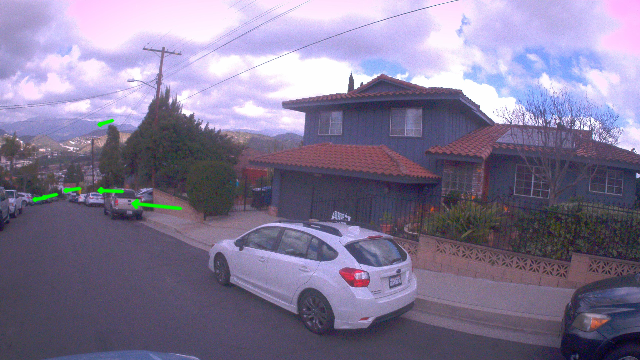

In [15]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models import detection
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import time
from IPython.display import clear_output, display
from PIL import Image
import io
import os

# Load the pre-trained car detection model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the Lucas-Kanade parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def resize_image(image, max_size=640):
    # First, crop the image
    height, width = image.shape[:2]
    start_width = width // 2
    end_width = 3 * width // 4
    image = image[:, start_width:end_width]

    # Then, resize the image
    height, width = image.shape[:2]
    scale_factor = max_size / max(height, width)
    if scale_factor < 1:
        new_size = (int(width * scale_factor), int(height * scale_factor))
        image = cv2.resize(image, new_size)

    return image
   
   
    # # image = img[:, :, int(img.shape[2] * 0.50):int(img.shape[2] * 0.75)]
    # height, width = image.shape[:2]
    # scale_factor = max_size / max(height, width)
    # if scale_factor < 1:
    #     new_size = (int(width * scale_factor), int(height * scale_factor))
    #     image = cv2.resize(image, new_size)
    # return image


def detect_cars(image):
    with torch.no_grad():
        transform = T.Compose([T.ToTensor()])
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)
        output = model(input_batch)
        boxes = output[0]["boxes"].numpy()
        scores = output[0]["scores"].numpy()

        # Filter boxes with a confidence score above 0.5
        boxes = boxes[scores >= 0.5]

    return boxes

def track_cars(prev_gray, next_gray, prev_points):
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, prev_points, None, **lk_params)
    status = status.ravel().astype(bool)
    moved_points = next_points[status]
    prev_points = prev_points[status]

    return prev_points, moved_points



def process_images(image_files):
    prev_gray = None
    prev_points = None

    # for img_path in image_files:
    #     image = cv2.imread(img_path)
    #     if image is None:
    #         print(f"Error loading image: {img_path}")
    #         continue

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img_path in enumerate(image_files):
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error loading image: {img_path}")
            continue
        image = resize_image(image)  # Add this line to resize the image

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if prev_gray is None:
            prev_gray = gray
            boxes = detect_cars(image)
            prev_points = np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in boxes], dtype=np.float32)
            continue

        prev_points, moved_points = track_cars(prev_gray, gray, prev_points)
        movement = moved_points - prev_points

        for i, (prev, next) in enumerate(zip(prev_points, moved_points)):
            a, b = next.ravel().astype(int)
            c, d = prev.ravel().astype(int)
            dist = np.linalg.norm(next - prev)

            # Change this threshold value to adjust the sensitivity of movement detection
            if dist > 2:
                cv2.arrowedLine(image, (a, b), (c, d), (0, 255, 0), 2, cv2.LINE_AA)

        # cv2_imshow(image)  # Use cv2_imshow instead of cv2.imshow
        # cv2.waitKey(500)  # Wait for 500 ms before showing the next frame
        # clear_output(wait=True)

        prev_gray = gray

        # Convert the image from BGR to RGB format and display it using IPython.display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(image))
        time.sleep(0.5)  # Wait for 500 ms before showing the next frame
        clear_output(wait=True)

    cv2.destroyAllWindows()

output_folder = "/content/drive/MyDrive/OUTPUT_FILES"    

# Replace the list with your own sequence of image files
image_files = ["color_image_48.jpg", "color_image_49.jpg", "color_image_50.jpg", "color_image_51.jpg", "color_image_52.jpg", "color_image_53.jpg", "color_image_54.jpg","color_image_254.jpg","color_image_255.jpg","color_image_256.jpg"]
process_images(image_files)


In [18]:
import cv2

def save_frames(video_file, output_folder, interval=1):
    cap = cv2.VideoCapture(video_file)

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the frame skip value. We'll only save one frame every 'frame_skip' frames.
    frame_skip = int(fps * interval)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()

        # Break the loop if we couldn't read a frame
        if not ret:
            break

        # If this frame is a 'frame_skip'-th frame, save it as an image
        if frame_count % frame_skip == 0:
            cv2.imwrite(f'frame_{frame_count}.jpg', frame)

        frame_count += 1

    cap.release()

# Replace 'your_video.lrv' with the path to your video file
save_frames('sample_vid.MP4', '/content/drive/MyDrive/SRI Lab/Frames')


In [19]:
%cd /content/drive/MyDrive/SRI Lab/frames
!ls
%pwd

/content/drive/MyDrive/SRI Lab/frames
frame_0.jpg	frame_1421.jpg	frame_1827.jpg	frame_2262.jpg	frame_609.jpg
frame_1015.jpg	frame_1450.jpg	frame_1856.jpg	frame_232.jpg	frame_638.jpg
frame_1044.jpg	frame_145.jpg	frame_1885.jpg	frame_261.jpg	frame_667.jpg
frame_1073.jpg	frame_1479.jpg	frame_1914.jpg	frame_290.jpg	frame_696.jpg
frame_1102.jpg	frame_1508.jpg	frame_1943.jpg	frame_29.jpg	frame_725.jpg
frame_1131.jpg	frame_1537.jpg	frame_1972.jpg	frame_319.jpg	frame_754.jpg
frame_1160.jpg	frame_1566.jpg	frame_2001.jpg	frame_348.jpg	frame_783.jpg
frame_116.jpg	frame_1595.jpg	frame_2030.jpg	frame_377.jpg	frame_812.jpg
frame_1189.jpg	frame_1624.jpg	frame_203.jpg	frame_406.jpg	frame_841.jpg
frame_1218.jpg	frame_1653.jpg	frame_2059.jpg	frame_435.jpg	frame_870.jpg
frame_1247.jpg	frame_1682.jpg	frame_2088.jpg	frame_464.jpg	frame_87.jpg
frame_1276.jpg	frame_1711.jpg	frame_2117.jpg	frame_493.jpg	frame_899.jpg
frame_1305.jpg	frame_1740.jpg	frame_2146.jpg	frame_522.jpg	frame_928.jpg
frame_1334.jpg	frame

'/content/drive/MyDrive/SRI Lab/frames'

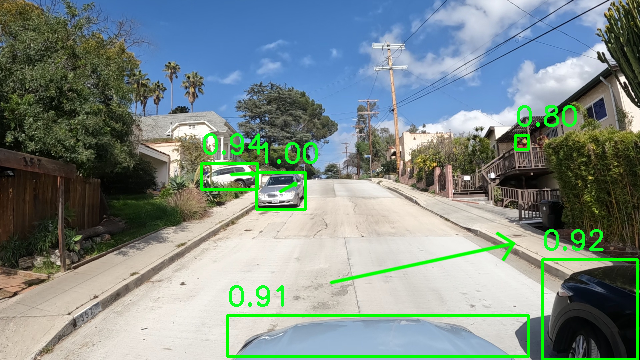

In [58]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models import detection
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import time
from IPython.display import clear_output, display
from PIL import Image
import io
import os

# Load the pre-trained car detection model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the Lucas-Kanade parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def resize_image(image, max_size=640):
    # First, crop the image
    height, width = image.shape[:2]
    # start_width = width // 2
    # end_width = 3 * width // 4
    # image = image[:, start_width:end_width]

    # Then, resize the image
    height, width = image.shape[:2]
    scale_factor = max_size / max(height, width)
    if scale_factor < 1:
        new_size = (int(width * scale_factor), int(height * scale_factor))
        image = cv2.resize(image, new_size)

    return image
   
   
    # # image = img[:, :, int(img.shape[2] * 0.50):int(img.shape[2] * 0.75)]
    # height, width = image.shape[:2]
    # scale_factor = max_size / max(height, width)
    # if scale_factor < 1:
    #     new_size = (int(width * scale_factor), int(height * scale_factor))
    #     image = cv2.resize(image, new_size)
    # return image


def detect_cars(image):
    with torch.no_grad():
        transform = T.Compose([T.ToTensor()])
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)
        output = model(input_batch)
        boxes = output[0]["boxes"].numpy()
        scores = output[0]["scores"].numpy()

        # Filter boxes with a confidence score above 0.5
        # boxes = boxes[scores >= 0.6]
        valid_indices = scores >= 0.80
        boxes = boxes[valid_indices]
        scores = scores[valid_indices]

    return boxes, scores

def track_cars(prev_gray, next_gray, prev_points):
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, prev_points, None, **lk_params)
    status = status.ravel().astype(bool)
    moved_points = next_points[status]
    prev_points = prev_points[status]

    return prev_points, moved_points


    # calculates the optical flow between two consecutive grayscale frames prev_gray and 
    # next_gray using the Lucas-Kanade method with the given prev_points. It returns the 
    # updated positions of the points in the next frame and the positions of the points that have moved.


def process_images(image_files):
    prev_gray = None
    prev_points = None
    moved_points = None  
    frame_counter = 0  # Added this to create unique names for each saved image


    # for img_path in image_files:
    #     image = cv2.imread(img_path)
    #     if image is None:
    #         print(f"Error loading image: {img_path}")
    #         continue

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img_path in enumerate(image_files):
        image = cv2.imread(img_path)
        # if image is None:
        #     print(f"Error loading image: {img_path}")
        #     continue
        image = resize_image(image)  # Add this line to resize the image

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect cars in the current frame
        boxes, scores = detect_cars(image)
        # if len(boxes) == 0: #uncomment these 3 lines if you want it to not save image if there are no cars detected 
        #     print(f"No cars detected in image: {img_path}")
        #     continue
        curr_points = np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in boxes], dtype=np.float32)

        
        # if prev_gray is not None and len(prev_points) > 0:  # Check if there are points to track
        if prev_gray is not None and prev_points is not None and len(prev_points) > 0:  # Check if there are points to track
            # Track movement of previously detected cars
            prev_points, moved_points = track_cars(prev_gray, gray, prev_points)
            movement = moved_points - prev_points

            # This part calculates the optical flow using the track_cars function and computes the movement by subtracting the previous points from the moved points.
            for i, (prev, next) in enumerate(zip(prev_points, moved_points)):
                a, b = next.ravel().astype(int)
                c, d = prev.ravel().astype(int)
                dist = np.linalg.norm(next - prev)

                # Change this threshold value to adjust the sensitivity of movement detection
                if dist > 2:
                    cv2.arrowedLine(image, (a, b), (c, d), (0, 255, 0), 2, cv2.LINE_AA)


        # if prev_gray is None:
        #     prev_gray = gray
        #     # boxes = detect_cars(image)
        #     boxes, scores = detect_cars(image)
        #     prev_points = np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in boxes], dtype=np.float32)
        # else:
        #     prev_points, moved_points = track_cars(prev_gray, gray, prev_points)
        #     movement = moved_points - prev_points

            

        # prev_points, moved_points = track_cars(prev_gray, gray, prev_points)
        # movement = moved_points - prev_points

        # # This part calculates the optical flow using the track_cars function and computes the movement by subtracting the previous points from the moved points.
        # for i, (prev, next) in enumerate(zip(prev_points, moved_points)):
        #     a, b = next.ravel().astype(int)
        #     c, d = prev.ravel().astype(int)
        #     dist = np.linalg.norm(next - prev)

        #     # Change this threshold value to adjust the sensitivity of movement detection
        #     if dist > 2:
        #         cv2.arrowedLine(image, (a, b), (c, d), (0, 255, 0), 2, cv2.LINE_AA)

        # cv2_imshow(image)  # Use cv2_imshow instead of cv2.imshow
        # cv2.waitKey(500)  # Wait for 500 ms before showing the next frame
        # clear_output(wait=True)

     ####   # prev_gray = gray

        # Draw bounding boxes and scores on the image
        # for (xmin, ymin, xmax, ymax), score in zip(boxes, scores):
        #     cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        #     cv2.putText(image, f"{score:.2f}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        # for (xmin, ymin, xmax, ymax), score in zip(boxes, scores):
        #     xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        #     cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        #     cv2.putText(image, f"{score:.2f}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

        for (xmin, ymin, xmax, ymax), score in zip(boxes, scores):
            xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, f"{score:.2f}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


        # continue

        # Convert the image from BGR to RGB format and display it using IPython.display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       
         # Create a unique name for each saved image
        image_name = f"output_{frame_counter}.jpg"
        cv2.imwrite(os.path.join(output_folder, image_name), image)
        frame_counter += 1  # Increment the counter
       
        display(Image.fromarray(image))
        time.sleep(0.5)  # Wait for 500 ms before showing the next frame
        clear_output(wait=True)

        prev_gray = gray
        if len(curr_points) > 0:  # Only update prev_points if curr_points is not empty
            prev_points = curr_points.copy()
        # prev_points = curr_points.copy()

    cv2.destroyAllWindows()

output_folder = "/content/drive/MyDrive/SRI Lab/GOPRO_OUTPUT_FILES"    

# Replace the list with your own sequence of image files
# image_files = ["color_image_48.jpg", "color_image_49.jpg", "color_image_50.jpg", "color_image_51.jpg", "color_image_52.jpg", "color_image_53.jpg", "color_image_54.jpg","color_image_254.jpg","color_image_255.jpg","color_image_256.jpg"]

# Get all files in the current directory
all_files = os.listdir()

# Filter out the ones that don't end with '.jpg' and store them in image_files
image_files = [file for file in all_files if file.endswith('.jpg')]

process_images(image_files)
